In [ ]:
%load_ext autoreload
%autoreload 2

import os
import re

import numpy as np
import torch

from rl4co.envs import EVRPTWEnv 
from milp import batch_milp, check_actions_with_mask


In [2]:
def enforce_reproducibility(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
results = []

# [num_loc, num_station, num_ev]
settings = [[10, 3, 3], [20, 3, 3], [50, 6, 6], [100, 12,12]]
solver_timelimit = 60
batch_size = 100

for num_loc, num_station, num_ev in settings:
    enforce_reproducibility(0)
    env = EVRPTWEnv(generator_params={'num_loc': num_loc, 
                                        'num_station': num_station,
                                        'vehicle_limit': num_ev,
                                        'vehicle_speed': 5,
                                        'vehicle_capacity': 1.25,
                                        'max_time': 1,
                                        'horizon': 1,
                                        'fuel_consumption_rate': 0.25,
                                        'inverse_recharge_rate': 0.25})
    td_init = env.reset(batch_size=[batch_size]).to('cuda')
    result = batch_milp(td_init, env, num_loc, num_station, num_ev, timelimit=solver_timelimit)

    results.append(result)

In [12]:
for r in results:
    print(f"C{r[0]:02d}-S{r[1]}-EV{r[2]} FeasibleCounts: {r[3]} AvgCost: {r[4]:.3f} AvgTime: {r[5]:.3f}")

C10-S3-EV3 FeasibleCounts: 100 AvgCost: 3.816 AvgTime: 7.104
C20-S3-EV3 FeasibleCounts: 98 AvgCost: 5.656 AvgTime: 56.704
C50-S6-EV6 FeasibleCounts: 14 AvgCost: 12.376 AvgTime: 60.333
C100-S12-EV12 FeasibleCounts: 1 AvgCost: 23.406 AvgTime: 60.500


# For Action Testing

In [5]:
# indicate a save filename in a folder save_milp related to this notebook
filename = "actions_c010_s3_v3_b100.pt"

In [ ]:
num_loc, num_station, num_ev, batch_size  = [int(num) for num in re.findall(r'\d+', filename)]
actions = torch.load(os.path.join("save_milp", filename))
enforce_reproducibility(0)
env = EVRPTWEnv(generator_params={'num_loc': num_loc, 
                                    'num_station': num_station,
                                    'vehicle_limit': num_ev,
                                    'vehicle_speed': 5,
                                    'vehicle_capacity': 1.25,
                                    'max_time': 1,
                                    'horizon': 1,
                                    'fuel_consumption_rate': 0.25,
                                    'inverse_recharge_rate': 0.25})
td_init = env.reset(batch_size=[batch_size]).to('cuda')

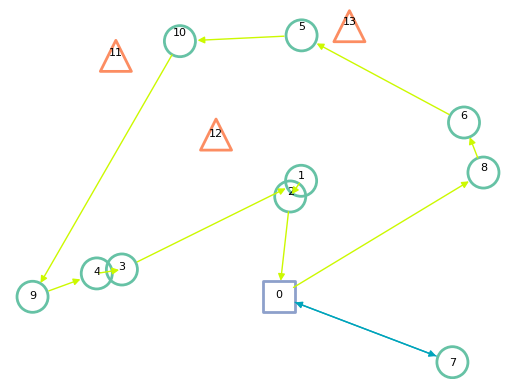

In [7]:
env.render(td_init[2], actions[2])

Note: Some negligible errors may appear below due to precision issues in the MILP solver, which uses a tolerance 10e-6

In [8]:
check_actions_with_mask(td_init, env, actions, display_errors=True)

Current Time: 0.114588201  Need: 0.058999848 Reach: 0.173588049
Time Windows [0.0, 0.17358775436878204]
Current Fuel 3.4270589351654053
Current Capacity 1.1571782231330872
Demand needed: 0.13609930872917175
Fail at instance 1 at node 5
Checked 100 results
Invalid instances no.: 1
